<a href="https://colab.research.google.com/github/brenoakihiromorimoto/portf-lio/blob/main/tera/Desafio_IFOOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Contexto Analítico

Vejam estas notícias:

Dados públicos de abril/21 - Em 2021, a empresa atingiu uma nova marca de 60 milhões de pedidos mensais. Crescimento de 100% em um ano; mais de 110.000 restaurantes se inscreveram na plataforma nos últimos 12 meses. Só em março, o mês mais letal da pandemia para o Brasil, 270 mil restaurantes operavam com a plataforma iFood.

Fonte: labsnews.com/en/articles/business/ifood-60-million-monthly-orders-amid-the-pandemic/

 … o iFood confirma a preferência pelos hambúrgueres no delivery. Foram, em média, quatro unidades por segundo, totalizando mais de 100 milhões de pedidos de opções como x-tudo, x-bacon, hambúrguer, x-burguer e x-salada.

…E, no iFood, conveniência de comprar marmitas prontas também entrou no ranking dos 10 mais pedidos pelos clientes.

Fonte: www.gazetadopovo.com.br/bomgourmet/negocios-e-franquias/mais-pedidos-delivery-2021

… “De zero a dez, quanto você recomendaria esta empresa a um parente ou amigo?” …. o método de “promoção e/ou programa de fidelidade” é desaprovado por 30,5% dos respondentes, seguido de agilidade e tempo de entrega (17,7%) e facilidade do uso dos aplicativos (14,0%). Em contrapartida, a qualidade de produtos é a característica mais aprovada pelos respondentes, com 93,2% de “likes”, seguida dos próprios restaurantes e estabelecimentos (89,0%) e entrega e/ou entregadores (86,9%).

A pergunta que dá vida à medição de NPS, de qualidade no atendimento, mostra o iFood como o aplicativo de delivery com melhor avaliação do mercado, com nota 59,8.

Quando o assunto é popularidade, o iFood segue sendo o aplicativo mais citado pelos respondentes, com 91,6% de citações.

Fonte: exame.com/negocios/nps-ifood-e-melhor-e-mais-popular-app-de-delivery-diz-pesquisa/

A diversidade e amplitude de clientes que utilizam a plataforma do iFood é gigante - a cobertura do aplicativo se estende por muitas geografias no Brasil, de múltiplos gostos, regionalismos e bolsos. Alguns buscam uma experiência no momento da refeição, outros só querem receber a marmita na hora certa para não se atrasar para a primeira reunião pós-almoço.

Neste contexto, precisamos entender melhor nossos clientes! Quem é o mais fiel e quem mais compra conosco? Quem mais gosta de cupom? Quem gosta de entrega grátis? Qual o padrão de consumo? Qual o padrão de comportamento? Quanto os clientes vão gastar? Onde?

# Resolução de Problemas
##Situação: 
Os clientes do Ifood são extremamente diversos, e é muito importante saber os hábitos e desejos desses clientes, porque as estratégias de marketing podem ser direcionadas de forma altamente eficiente. 
## Tarefa:
* **Pergunta principal**: a primeira pergunta a ser respondida é: **quais são os clientes mais fiéis e quem mais compra no Ifood?** Porque provavelmente esses clientes gerarão mais receita para a empresa a longo prazo.
* **Perguntas secundárias**: compreendendo os grupos de clientes feitos a partir do K-ShiftMeans, algumas perguntas podem ser respondidas imediatamente: 
  * Onde moram?
  * Eles gostam de entrega grátis?
  * Qual é o tipo de comida eles mais pedem?

## Ação:
* **Ações da tarefa principal:**
  * Verificar dados nulos no dataset  orders.
  * A fidelidade de um cliente pode ser feita a partir da Análise por RMF (Recência, Frequência e Valor Monetário).
  * Usar o K-means para agrupar os clientes por grau de fidelidade.
  * Verificar estabilidade do cluster.
* **Ações das tarefas secundárias:**
  * Filtrar a partir dos clusters.

# Importar bibliotecas.

In [ ]:
!pip install kmodes

In [ ]:
import pandas as pd
import numpy as np
from numpy import where, unique
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from google.colab import drive
from datetime import datetime
from sklearn.cluster import MeanShift, KMeans
from statistics import mode
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, levene
from sklearn.cluster import KMeans 
from kmodes.kprototypes import KPrototypes 
from sklearn.preprocessing import RobustScaler
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
from yellowbrick.cluster import InterclusterDistance
from matplotlib import cm
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import statsmodels.api as sm
drive.mount('/gdrive')
%cd /gdrive

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /gdrive
/gdrive


#Quais são os clientes mais fiéis e quem mais compra no ifood?

# Importar dataset

In [ ]:
link = "/gdrive/MyDrive/Colab Notebooks/Tera/IFOOD"
ordens = pd.read_csv(link+'/Orders.xls', sep=';')

# Função

In [ ]:
def hypothesis_test(group_A, group_B):
  stats_group_a, p_group_a = shapiro(group_A)
  stats_group_b, p_group_b = shapiro(group_B)
  print('Teste de Shapiro-Wilk: valor-p do grupo A: %.3f, valor-p do Grupo B: %.3f.' % (p_group_a, p_group_b))
  if p_group_a>=0.05 and p_group_b>=0.05:
    stats_levene, p_levene = levene(group_A,
                     group_B)
    print('O Teste de Shapiro-Wilk demonstrou que os grupos têm distribuição normal dos dados.')
    print('Teste de Levene: stats: %.3f, valor-p: %.3f.' % (stats_levene, p_levene))
    if p_levene>=0.05:
      stats_ttest, p_ttest = ttest_ind(group_A,
                          group_B, equal_var=True)
      print(f"O teste de Levene demonstrou que a variância é igual nos dois grupos: p-valor de %.3f." % (p_levene))

      print('Teste-t independente: stats: %.3f, valor-p: %.3f.' % (stats_ttest, p_ttest))
    elif p_levene<0.05:
      stats_ttest, p_ttest = ttest_ind(group_A,
                          group_B, equal_var=False)
      
      print(f"O teste de Levene demonstrou que a variância é significantemente diferente nos dois grupos: p-valor de %.3f." % (p_levene))
      if p_ttest>=0.05:
        print(f"O teste-t independente demonstrou diferença significativa das médias dos dois grupos: p-valor de %.3f." % (p_ttest))
      elif p_ttest<0.05:
        print(f"O teste-t independente não demonstrou diferença significativa das médias dos dois grupos: p-valor de %.3f." % (p_ttest))
  elif p_group_a<0.05 or p_group_b<0.05:
    stats_mann, p_mann = mannwhitneyu(group_A, group_B)
    print('O Teste de Shapiro-Wilk demonstrou que, no mínimo, algum dos dois grupos não tem distribuição normal dos dados.')
    print('Teste de Mann-Whitney-U: stats: %.3f, valor-p: %.3f.' % (stats_mann, p_mann))
    if p_mann>=0.05:
      print("O teste Mann-Whitney-U não demonstrou diferença significativa das medianas dos dois grupos: p-valor de %.3f." % (p_mann))
    elif p_mann<0.05:
      print("O teste Mann-Whitney-U demonstrou diferença significativa das medianas dos dois grupos: p-valor de %.3f." % (p_mann))


# Primeiro contato e redução de dimensionalidade.

In [ ]:
ordens.head(3)

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,...,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,875.0,False,5375.0,0.00,ANDROID,MOBILE,9.39.1,...,-43.38,-22.83,False,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8,2020-02-28T19:06:31.861Z
1,0018ed39-3ae0-4047-9c9e-fd9a2027e645,weekend dinner,RESTAURANT,0.0,False,2987.5,1250.00,IOS,MOBILE,9.63.0,...,-43.22,-22.93,True,2020-08-21T21:12:23.295Z,2020-08-21T21:59:18.732Z,1.0,407bab9f-f485-48cd-abea-66e6283058c3,5.0,8,2020-09-04T00:14:14.365Z
2,00214248-5a2d-4333-a919-c1f3afd31389,weekday dinner,RESTAURANT,0.0,False,3737.5,2123.75,IOS,MOBILE,9.56.0,...,-46.67,-23.62,True,2020-07-02T20:21:51.900Z,2020-07-02T20:53:39.176Z,3.0,a16865d2-a3ca-4251-afab-083dadeb06e9,5.0,5,2020-07-03T03:49:03.214Z


In [ ]:
ordens.tail(3)

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,...,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at
226266,ff54b0d0-6bd3-4bad-a34c-ec64f0b17787,weekday dinner,RESTAURANT,875.0,False,8512.50,1.25,IOS,MOBILE,9.48.0,...,-46.69,-23.60,False,2020-04-29T20:18:36.920Z,2020-04-30T00:18:36.307Z,2.0,2ae2d0e7-ecde-42f3-baf7-a2391f3fc360,5.0,10,2020-05-04T23:33:37.180Z
226267,ff5baa22-a12c-4482-acaf-3e7831a1e764,weekday breakfast,RESTAURANT,0.0,False,3500.00,873.75,ANDROID,MOBILE,9.68.2,...,-43.19,-22.94,True,2020-09-24T09:35:59.186Z,2020-09-24T09:59:05.377Z,1.0,5891f31c-a328-42df-88d7-5e1a7f6dce2a,4.0,1,2020-09-24T13:53:18.336Z
226268,ff72056f-0530-4d33-9180-b9b735817edb,weekend snack,RESTAURANT,612.5,False,5093.75,0.00,ANDROID,MOBILE,9.54.0,...,-46.72,-23.59,False,2020-06-21T16:49:12.157Z,2020-06-21T20:49:12.262Z,0.0,a392006f-4228-486f-9844-4647c6489d90,5.0,10,2020-06-21T22:21:54.666Z


In [ ]:
ordens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              226269 non-null  object 
 1   order_shift           226269 non-null  object 
 2   order_origin          226269 non-null  object 
 3   delivery_fee          226269 non-null  float64
 4   scheduled             226269 non-null  bool   
 5   total_amount          226269 non-null  float64
 6   subsidy_amount        226269 non-null  float64
 7   device_platform       226269 non-null  object 
 8   device_type           226269 non-null  object 
 9   device_app_version    221834 non-null  object 
 10  centroid_id           226269 non-null  object 
 11  state_label           226269 non-null  object 
 12  city                  226269 non-null  object 
 13  district              226269 non-null  object 
 14  customer_long         226269 non-null  float64
 15  

* Há muitas variáveis nesse dataset, praticamente **34**!  
* É melhor reduzir a dimensionalidade de acordo com as tarefas já mencionadas, isso economiza tempo na EDA, teste de hipótese, pré-processamento e modelagem.

* Features selecionadas:
  * order_id
  * order_origin
  * account_id
  * state_label
  * city
  * confirmed_date
  * concluded_date
  * total_amount
  * has_free_delivery
  * dish_type

* Criar um novo dataset com essas 10 variáveis.

In [ ]:
features_ordens =  ["order_id",
                    "order_origin",
                    "account_id",
                    "state_label",
                    "city",
                    "confirmed_date",
                    "concluded_date",
                    "total_amount",
                    "has_free_delivery",
                    "dish_type"]

ordens_10_var = ordens[features_ordens]

In [ ]:
ordens_10_var.head(3)

,order_id,order_origin,account_id,state_label,city,confirmed_date,concluded_date,total_amount,has_free_delivery,dish_type
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,RESTAURANT,70a2a5a3-8071-47fc-a623-e9995045314e,RJ,RIO DE JANEIRO,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z,5375.0,False,Comida Brasileira
1,0018ed39-3ae0-4047-9c9e-fd9a2027e645,RESTAURANT,407bab9f-f485-48cd-abea-66e6283058c3,RJ,RIO DE JANEIRO,2020-08-21T21:12:23.295Z,2020-08-21T21:59:18.732Z,2987.5,True,Comida Brasileira
2,00214248-5a2d-4333-a919-c1f3afd31389,RESTAURANT,a16865d2-a3ca-4251-afab-083dadeb06e9,SP,SAO PAULO,2020-07-02T20:21:51.900Z,2020-07-02T20:53:39.176Z,3737.5,True,Comida Peruana


In [ ]:
ordens_10_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           226269 non-null  object 
 1   order_origin       226269 non-null  object 
 2   account_id         226269 non-null  object 
 3   state_label        226269 non-null  object 
 4   city               226269 non-null  object 
 5   confirmed_date     226255 non-null  object 
 6   concluded_date     226265 non-null  object 
 7   total_amount       226269 non-null  float64
 8   has_free_delivery  226269 non-null  bool   
 9   dish_type          226269 non-null  object 
dtypes: bool(1), float64(1), object(8)
memory usage: 15.8+ MB


# Dados nulos

Perguntas a serem respondidas:
* Por que o confirmed_date e o concluded_date tem dados nulos?
* Por que has_free_delivery tem um dado nulo?
* Por que account_id tem um dado nulo?

### confirmed_date e concluded_date

In [ ]:
ordens_10_var[ordens_10_var["confirmed_date"].isnull()][["confirmed_date", "concluded_date"]]

,confirmed_date,concluded_date
14218,NaN,2020-02-18T18:31:31.464Z
27814,NaN,2020-02-18T18:33:34.004Z
32263,NaN,2020-02-18T18:34:33.993Z
81774,NaN,2020-02-18T12:54:15.820Z
99762,NaN,2020-02-18T12:42:37.912Z
100774,NaN,2020-02-18T18:31:31.309Z
102572,NaN,2020-02-18T18:36:29.340Z
112282,NaN,2020-02-18T18:36:40.085Z
117261,NaN,2020-02-18T18:36:29.254Z
143533,NaN,2020-02-18T18:36:30.491Z


* No mesmo dia, 12 pedidos tiveram a data confirmada como nulo. 
* Provavelmente foi um erro no sistema, porque todos os dados nulos da data confirmada ocorreram no dia 18 de Fevereiro de 2020.
* E os dados nulos do concluded_date?

In [ ]:
ordens_10_var[ordens_10_var["concluded_date"].isnull()][["confirmed_date", "concluded_date"]]

,confirmed_date,concluded_date
133822,2020-05-30T10:50:53.463Z,NaN
144676,2020-08-13T08:34:31.033Z,NaN
187989,2020-06-01T08:55:51.283Z,NaN
201756,2020-08-13T08:24:25.120Z,NaN


* O concluded_date não mostra um padrão evidente de dados nulos
* Podemos presumir, por enquanto, erro no sistema.
* No pré-rpocessamento, é necessário transformar as variáveis confirmed_date e concluded_date em datetime para facilitar análises futuras.

### has_free_delivery e account_id

In [ ]:
ordens_10_var[ordens_10_var['has_free_delivery'].isnull()]

,order_id,order_origin,account_id,state_label,city,confirmed_date,concluded_date,total_amount,has_free_delivery,dish_type


* Provavelmente, houve um erro no sistema ao registrar o account_id, e isso gerou dados nulos para a variável has_free_delivery.

# Pré-processamento

* O algoritmo de machine learning será o de **clustering**. 
* Já que estou usando **método não-supervisionado**, não será colocado em produção, apenas como estudo e geração de insights, portanto não será necessário dividir em **treino, validação e teste**.
* Remover a linha com o order_id nulo, porque há muitos dados nulos nessa linha.
* Remover a variável confirmed_date, para a análise preciso apenas a concluded_date.
* Remover os dados nulos da variável concluded_date.
Por que remover os dados?
São poucos dados nulos, entorno de 3 linhas em um dataset de 160 mil linhas, então irei remover para simplificar a análise.

In [ ]:
# Reduzir dimensionalidade do dataset ao alinhar expectativas.
features_ordens =  ["order_id",
                    "order_origin",
                    "account_id",
                    "state_label",
                    "city",
                    "concluded_date",
                    "total_amount",
                    "has_free_delivery",
                    "dish_type"]

ordens_preprocessed = ordens[features_ordens].copy()

# Transformar as colunas concluded_date e confirmed_date para datetime, isso irá ajudar em manipulações futuras.
ordens_preprocessed.loc[ordens_preprocessed["concluded_date"].notnull(), "concluded_date"] = ordens_preprocessed[ordens_preprocessed["concluded_date"].notnull()]["concluded_date"].str[:-5].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%dT%H:%M:%S"))
#ordens_10_var_preprocessed.loc[ordens_10_var_preprocessed["confirmed_date"].notnull(), "confirmed_date"] = ordens_10_var_preprocessed[ordens_10_var_preprocessed["confirmed_date"].notnull()]["confirmed_date"].str[:-5].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%dT%H:%M:%S"))

ordens_preprocessed["concluded_date"] = pd.to_datetime(ordens_preprocessed["concluded_date"])
#ordens_10_var_preprocessed["confirmed_date"] = pd.to_datetime(ordens_10_var_preprocessed["confirmed_date"])

In [ ]:
ordens_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   order_id           226269 non-null  object        
 1   order_origin       226269 non-null  object        
 2   account_id         226269 non-null  object        
 3   state_label        226269 non-null  object        
 4   city               226269 non-null  object        
 5   concluded_date     226265 non-null  datetime64[ns]
 6   total_amount       226269 non-null  float64       
 7   has_free_delivery  226269 non-null  bool          
 8   dish_type          226269 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), object(6)
memory usage: 14.0+ MB


* Remover os dados nulos.

In [ ]:
ordens_preprocessed = ordens_preprocessed.dropna(axis=0)

In [ ]:
ordens_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226265 entries, 0 to 226268
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   order_id           226265 non-null  object        
 1   order_origin       226265 non-null  object        
 2   account_id         226265 non-null  object        
 3   state_label        226265 non-null  object        
 4   city               226265 non-null  object        
 5   concluded_date     226265 non-null  datetime64[ns]
 6   total_amount       226265 non-null  float64       
 7   has_free_delivery  226265 non-null  bool          
 8   dish_type          226265 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), object(6)
memory usage: 15.8+ MB


* Pronto!

# Feature Engineering

In [ ]:
ordens_preprocessed['Recency'] = ordens_preprocessed['concluded_date']
ordens_preprocessed['Frequency'] = ordens_preprocessed['concluded_date']
ordens_preprocessed['Monetary_Value'] = ordens_preprocessed['total_amount']

ordens_preprocessed_RMF = ordens_preprocessed.sort_values(by='Recency', 
                                                          ascending=False)\
                                                          .groupby('account_id')\
                                                          .agg({'Recency': lambda date: \
                                                                pd.to_datetime(datetime.today()) - \
                                                                pd.to_datetime(date.value_counts().index[0]),
                                                          'Monetary_Value': lambda total_amount: total_amount.sum(),
                                                          'Frequency': lambda concluded_date:concluded_date.value_counts().sum(),
                                                          'has_free_delivery': lambda delivery:delivery.value_counts().index[0],
                                                          'city': lambda city:city.value_counts().index[0]})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
ordens_preprocessed_RMF.head(3)

,Recency,Monetary_Value,Frequency,has_free_delivery,city
account_id,,,,,
00073adf-7117-44ba-90fe-5879c9581b68,818 days 23:57:22.625110,2737.50,1,True,CURITIBA
000b1fec-8616-4014-9581-c5a944911ac3,624 days 14:30:38.626310,18671.25,4,False,RIO DE JANEIRO
000db136-b110-4dd6-9d1c-a70ab1ab2d75,584 days 22:28:31.627024,105322.50,26,True,SAO PAULO


* Rencency precisa ser transformado em **int**.

In [ ]:
ordens_preprocessed_RMF['Recency_days'] = np.nan
for i in range(len(ordens_preprocessed_RMF)):
    ordens_preprocessed_RMF['Recency_days'][i] = ordens_preprocessed_RMF['Recency'][i].days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


* Remover Recency

In [ ]:
ordens_preprocessed_RMF = ordens_preprocessed_RMF.drop('Recency', axis=1)

In [ ]:
# normalizar o RMF
from sklearn.preprocessing import MinMaxScaler
ordens_preprocessed_RMF['Recency_days_norm'] = MinMaxScaler().fit_transform(X=1/ordens_preprocessed_RMF[['Recency_days']])*100
ordens_preprocessed_RMF['Frequency_norm'] = MinMaxScaler().fit_transform(X=ordens_preprocessed_RMF[['Frequency']])*100
ordens_preprocessed_RMF['Monetary_Value_norm'] = MinMaxScaler().fit_transform(X=ordens_preprocessed_RMF[['Monetary_Value']])*100

ordens_preprocessed_RMF['CLTV'] = (((ordens_preprocessed_RMF['Frequency_norm'].astype(float) + ordens_preprocessed_RMF['Monetary_Value_norm'].astype(float)) + (ordens_preprocessed_RMF['Recency_days_norm'].astype(float)))/3).round(2)

In [ ]:
ordens_preprocessed_RMF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13964 entries, 00073adf-7117-44ba-90fe-5879c9581b68 to fffeddb7-19ce-4a16-999a-41f5fed5fc96
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Monetary_Value       13964 non-null  float64
 1   Frequency            13964 non-null  int64  
 2   has_free_delivery    13964 non-null  bool   
 3   city                 13964 non-null  object 
 4   Recency_days         13964 non-null  float64
 5   Recency_days_norm    13964 non-null  float64
 6   Frequency_norm       13964 non-null  float64
 7   Monetary_Value_norm  13964 non-null  float64
 8   CLTV                 13964 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(1)
memory usage: 1.5+ MB


### Adicionar dish_type

In [ ]:
ordens_preprocessed_RMF = ordens_preprocessed_RMF.reset_index()

In [ ]:
ordens_preprocessed_dish_type = ordens_preprocessed[["account_id", "dish_type"]]\
.groupby("account_id").agg(lambda x:x.mode()).reset_index()

In [ ]:
ordens_preprocessed_full = pd.merge(ordens_preprocessed_RMF, 
                                         ordens_preprocessed_dish_type, 
                                         how="inner", 
                                         on="account_id")

In [ ]:
ordens_preprocessed_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13964 entries, 0 to 13963
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   account_id           13964 non-null  object 
 1   Monetary_Value       13964 non-null  float64
 2   Frequency            13964 non-null  int64  
 3   has_free_delivery    13964 non-null  bool   
 4   city                 13964 non-null  object 
 5   Recency_days         13964 non-null  float64
 6   Recency_days_norm    13964 non-null  float64
 7   Frequency_norm       13964 non-null  float64
 8   Monetary_Value_norm  13964 non-null  float64
 9   CLTV                 13964 non-null  float64
 10  dish_type            13964 non-null  object 
dtypes: bool(1), float64(6), int64(1), object(3)
memory usage: 1.2+ MB


In [ ]:
ordens_preprocessed_full.head(2)

,account_id,Monetary_Value,Frequency,has_free_delivery,city,Recency_days,Recency_days_norm,Frequency_norm,Monetary_Value_norm,CLTV,dish_type
0,00073adf-7117-44ba-90fe-5879c9581b68,2737.50,1,True,CURITIBA,818.0,2.049564,0.000000,0.049463,0.70,Marmita
1,000b1fec-8616-4014-9581-c5a944911ac3,18671.25,4,False,RIO DE JANEIRO,624.0,77.148623,0.360144,0.341500,25.95,"[Comida Brasileira, Lanches, Pizza, Tapioca]"


# EDA

## Experimento 1 - Clusterização com CLTV

* Será que clusterizar com apenas o CLTV gera insights sobre gostar de entrega grátis?

In [ ]:
ordens_EDA_experimento_1 = ordens_preprocessed_full.copy()

In [ ]:
kmeans = KMeans()

In [ ]:
ordens_EDA_experimento_1.describe(percentiles=[.25, .5, .75, .99]).round(2)

,Monetary_Value,Frequency,Recency_days,Recency_days_norm,Frequency_norm,Monetary_Value_norm,CLTV
count,13964.00,13964.00,13964.00,13964.00,13964.00,13964.00,13964.00
mean,97510.06,16.20,663.52,61.83,1.83,1.79,21.81
std,226683.72,38.99,74.48,31.64,4.68,4.15,11.51
min,38.75,1.00,582.00,0.00,0.00,0.00,0.01
25%,9862.50,2.00,599.00,35.69,0.12,0.18,12.50
50%,26323.75,4.00,638.00,70.20,0.36,0.48,23.98
75%,79867.50,12.00,718.00,90.36,1.32,1.46,31.20
99%,1124727.04,185.00,822.00,100.00,22.09,20.61,45.43
max,5456118.75,834.00,825.00,100.00,100.00,100.00,83.40


* No CLTV, há outliers pela comparação do percentil 99% e o máximo.
* Será necessário usar o RobustScaler para o outlier não influenciar no clustering.

### Ajuste de escala

In [ ]:
CLTV = ordens_EDA_experimento_1[['CLTV']]
CLTV_scaled = RobustScaler().fit_transform(CLTV)

In [ ]:
CLTV_scaled = pd.DataFrame(CLTV_scaled)
CLTV_scaled = CLTV_scaled.rename(columns={0: "CLTV"})

In [ ]:
CLTV_scaled.head(3)

,CLTV
0,-1.244920
1,0.105348
2,0.567380


In [ ]:
CLTV_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13964 entries, 0 to 13963
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CLTV    13964 non-null  float64
dtypes: float64(1)
memory usage: 109.2 KB


### Visualização pelo método do cotovelo.

Text(0, 0.5, 'Inertia')

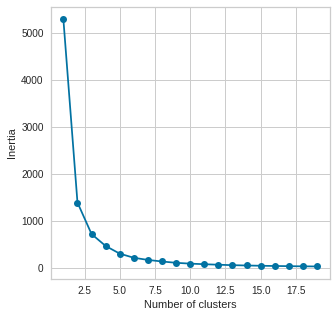

In [ ]:
# Fitando vários modelos e armazenando inércia na lista SSE
SSE = []
for cluster in range(1, 20):  
  kmeans = KMeans(n_clusters=cluster, init="k-means++", n_init=10)
  kmeans.fit(CLTV_scaled)
  SSE.append(kmeans.inertia_)

# Convertendo os resultados em um dataframe
frame = pd.DataFrame({'Cluster': range(1, 20),
                      'SSE': SSE})
plt.figure(figsize=(5, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

* A partir de 5 clusters, há estabilidade nos grupos.

### Visualização pelo método da silhueta score.

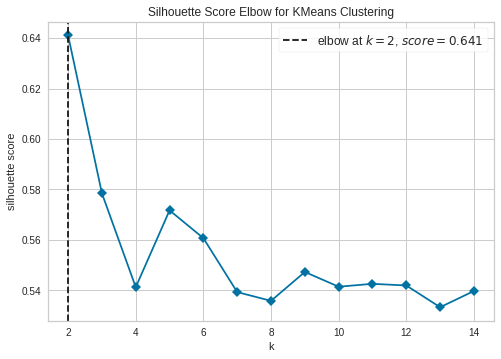

In [ ]:
model = KMeans(random_state=0, init = 'k-means++', n_init = 10, max_iter=100) 

visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings=False)

visualizer.fit(CLTV_scaled)    
visualizer.poof()

* Os clusters estão bem separados quando há 2, 3 e 5 clusters.


### Visualização dos clusters e a distância entre eles

* A quantidade de clusters no k-means será 5 pelo método do cotovelo e silhueta score.

InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f190259e350>,
                     estimator=KMeans(max_iter=100, n_clusters=5,
                                      random_state=0),
                     random_state=0)

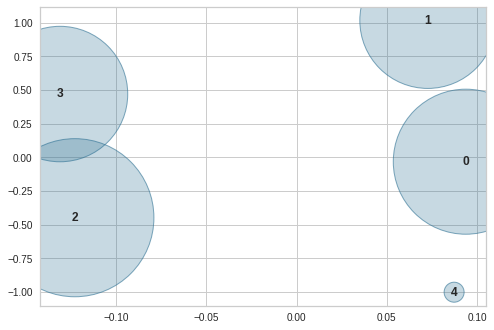

In [ ]:
model = KMeans(5, init="k-means++", n_init=10, max_iter=100, random_state=0)
visualizer = InterclusterDistance(model, random_state=0)
visualizer.fit(CLTV_scaled)

* Alguns clusters estão interseccionando entre si, o que não é bom porque a distância intercluster precisa ser a maior possível.
* E se eu colocar mais variáveis?

## Experimento 2

In [ ]:
ordens_EDA_experimento_2 = ordens_preprocessed_full.copy()

In [ ]:
ordens_EDA_experimento_2.sample(3, random_state=0)

,account_id,Monetary_Value,Frequency,has_free_delivery,city,Recency_days,Recency_days_norm,Frequency_norm,Monetary_Value_norm,CLTV,dish_type
8114,9600c2b2-0ebb-4496-b3c2-5c572baec274,15487.50,3,False,SAO PAULO,639.0,69.715412,0.240096,0.283147,23.41,"[Comida Brasileira, Comida Chinesa, Lanches]"
4951,5d0d809e-d6fd-4f18-acd7-d69594190962,889827.50,102,False,SAO PAULO,582.0,100.000000,12.124850,16.308206,42.81,Comida Brasileira
4629,573ff972-887a-403a-8db0-54b8fdaee951,30356.25,8,False,RIO DE JANEIRO,587.0,97.108125,0.840336,0.555665,32.83,Doces & Bolos


### Remover colunas

* Irei remover as colunas que não serão utilizadas no experimento.

In [ ]:
ordens_EDA_experimento_2.drop(["Monetary_Value",
                               "Frequency",
                               "Recency_days",
                               "Recency_days_norm",
                               "Frequency_norm",
                               "Monetary_Value_norm"], axis=1, inplace=True)

In [ ]:
ordens_EDA_experimento_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13964 entries, 0 to 13963
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   account_id         13964 non-null  object 
 1   has_free_delivery  13964 non-null  bool   
 2   city               13964 non-null  object 
 3   CLTV               13964 non-null  float64
 4   dish_type          13964 non-null  object 
dtypes: bool(1), float64(1), object(3)
memory usage: 559.1+ KB


In [ ]:
ordens_EDA_experimento_2.account_id.nunique()

13964

* Cada account_id é único.

In [ ]:
ordens_EDA_experimento_2.city.nunique()

232

* A feature city é de alta cardinalidade

### Ajuste de escala e mudar registro

In [ ]:
ordens_EDA_experimento_2.set_index("account_id", inplace=True)

In [ ]:
ordens_EDA_experimento_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13964 entries, 00073adf-7117-44ba-90fe-5879c9581b68 to fffeddb7-19ce-4a16-999a-41f5fed5fc96
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   has_free_delivery  13964 non-null  bool   
 1   city               13964 non-null  object 
 2   CLTV               13964 non-null  float64
 3   dish_type          13964 non-null  object 
dtypes: bool(1), float64(1), object(2)
memory usage: 450.0+ KB


In [ ]:
# Ajustar a escala do CLTV com RobustScaler
ordens_EDA_experimento_2["CLTV_scaled"] = RobustScaler().fit_transform(ordens_EDA_experimento_2[["CLTV"]])

# Remover CLTV
ordens_EDA_experimento_2.drop("CLTV", axis=1, inplace=True)

In [ ]:
ordens_EDA_experimento_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13964 entries, 00073adf-7117-44ba-90fe-5879c9581b68 to fffeddb7-19ce-4a16-999a-41f5fed5fc96
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   has_free_delivery  13964 non-null  bool   
 1   city               13964 non-null  object 
 2   dish_type          13964 non-null  object 
 3   CLTV_scaled        13964 non-null  float64
dtypes: bool(1), float64(1), object(2)
memory usage: 450.0+ KB


### Transformar o dish_type em um novo dataset.

In [ ]:
ordens_EDA_experimento_2_dish_type = ordens_EDA_experimento_2.dish_type.apply(pd.Series)

In [ ]:
ordens_EDA_experimento_2_dish_type.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13964 entries, 00073adf-7117-44ba-90fe-5879c9581b68 to fffeddb7-19ce-4a16-999a-41f5fed5fc96
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       13964 non-null  object
 1   1       3404 non-null   object
 2   2       1146 non-null   object
 3   3       364 non-null    object
 4   4       107 non-null    object
 5   5       46 non-null     object
 6   6       15 non-null     object
 7   7       6 non-null      object
 8   8       3 non-null      object
 9   9       1 non-null      object
dtypes: object(10)
memory usage: 1.2+ MB


In [ ]:
ordens_EDA_experimento_2["dishtype_01"] = ordens_EDA_experimento_2_dish_type[0]

In [ ]:
ordens_EDA_experimento_2.head(3)

,has_free_delivery,city,dish_type,CLTV_scaled,dishtype_01
account_id,,,,,
00073adf-7117-44ba-90fe-5879c9581b68,True,CURITIBA,Marmita,-1.244920,Marmita
000b1fec-8616-4014-9581-c5a944911ac3,False,RIO DE JANEIRO,"[Comida Brasileira, Lanches, Pizza, Tapioca]",0.105348,Comida Brasileira
000db136-b110-4dd6-9d1c-a70ab1ab2d75,True,SAO PAULO,Lanches,0.567380,Lanches


In [ ]:
ordens_EDA_experimento_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13964 entries, 00073adf-7117-44ba-90fe-5879c9581b68 to fffeddb7-19ce-4a16-999a-41f5fed5fc96
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   has_free_delivery  13964 non-null  bool   
 1   city               13964 non-null  object 
 2   dish_type          13964 non-null  object 
 3   CLTV_scaled        13964 non-null  float64
 4   dishtype_01        13964 non-null  object 
dtypes: bool(1), float64(1), object(3)
memory usage: 559.1+ KB


In [ ]:
ordens_EDA_experimento_2.drop("dish_type", axis=1, inplace=True)

In [ ]:
ordens_EDA_experimento_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13964 entries, 00073adf-7117-44ba-90fe-5879c9581b68 to fffeddb7-19ce-4a16-999a-41f5fed5fc96
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   has_free_delivery  13964 non-null  bool   
 1   city               13964 non-null  object 
 2   CLTV_scaled        13964 non-null  float64
 3   dishtype_01        13964 non-null  object 
dtypes: bool(1), float64(1), object(2)
memory usage: 450.0+ KB


### Visualização pelo método do cotovelo

Text(0, 0.5, 'Inertia')

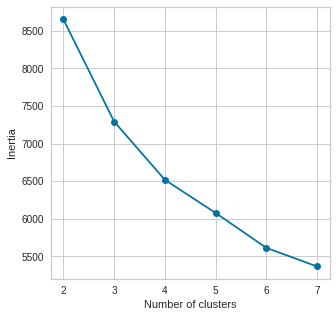

In [ ]:
# Fitando vários modelos e armazenando inércia na lista SSE
SSE = []
for cluster in range(2, 8):  
  k_proto = KPrototypes(n_clusters=cluster, max_iter=100, init="Cao", n_init=10, random_state=0)
  k_proto.fit(ordens_EDA_experimento_2[all_features], categorical=categorical_data)
  SSE.append(k_proto.cost_)

# Convertendo os resultados em um dataframe
frame = pd.DataFrame({'Cluster': range(2, 8),
                      'SSE': SSE})
plt.figure(figsize=(5, 5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
k_proto.cluster_centroids_

### Aplicar KPrototypes

In [449]:
# índices das colunas contendo dados categóricos
categorical_data = [0, 1, 3]
all_features = ["has_free_delivery",
                "city",
                "CLTV_scaled",
                "dishtype_01"]

In [450]:
k_proto = KPrototypes(n_clusters=5, max_iter=100, init="Cao", n_init=10, random_state=0)
ordens_EDA_experimento_2["clustering_k_prototype"] = k_proto.fit_predict(ordens_EDA_experimento_2, categorical=categorical_data)

### Sumarizar clusters de forma padronizada.

* Os valores dos clusters mudam o tempo todo, é necessário um método de padronização para a análise ficar reproduzível. Por exemplo, o mesmo centroide do cluster 0 pode mudar para o cluster 4, o que inviabiliza qualquer análise iterativa.

In [451]:
from statistics import mode
# Agrupar por clustering
clustering_summary = ordens_EDA_experimento_2.groupby("clustering_k_prototype").agg({"has_free_delivery": lambda x:x.mode(),
                                                                "city": lambda x:x.mode(),
                                                                "dishtype_01": lambda x:x.mode(),
                                                                "CLTV_scaled": lambda x:x.median()})

# Resetar o index para substituir os valores de clustering, 
# porque o kprototype mantém os centroides, mas troca o número do cluster toda vez que inicializa.
clustering_summary.reset_index(inplace=True)

# Para a análise se tornar reprodutível, irei criar um filtro com a função loc,
# toda vez que mudar o número de clustering, este código irá alterá-lo de acordo
# com o experimento feito.

# Cluster 0
# Armazenar número do cluster errado
cluster_0_k_prototype = clustering_summary.loc[(clustering_summary["CLTV_scaled"]<=-0.8)\
                       & (clustering_summary["dishtype_01"]=="Lanches") \
                       & (clustering_summary["city"]=="SAO PAULO") \
                       & (clustering_summary["has_free_delivery"]==False), "clustering_k_prototype"]
# Transformar o valor do cluster corretamente
clustering_summary.loc[(clustering_summary["CLTV_scaled"]<=-0.8)\
                       & (clustering_summary["dishtype_01"]=="Lanches") \
                       & (clustering_summary["city"]=="SAO PAULO") \
                       & (clustering_summary["has_free_delivery"]==False), "clustering_k_prototype"] = 0

# Cluster 1
# Armazenar número do cluster errado
cluster_1_k_prototype = clustering_summary.loc[(clustering_summary["CLTV_scaled"]>=0.04)\
                       & (clustering_summary["CLTV_scaled"]<=0.05)\
                       & (clustering_summary["dishtype_01"]=="Comida Brasileira") \
                       & (clustering_summary["city"]=="RIO DE JANEIRO") \
                       & (clustering_summary["has_free_delivery"]==True), "clustering_k_prototype"]

# Transformar o valor do cluster corretamente
clustering_summary.loc[(clustering_summary["CLTV_scaled"]>=0.04)\
                       & (clustering_summary["CLTV_scaled"]<=0.05)\
                       & (clustering_summary["dishtype_01"]=="Comida Brasileira") \
                       & (clustering_summary["city"]=="RIO DE JANEIRO") \
                       & (clustering_summary["has_free_delivery"]==True), "clustering_k_prototype"] = 1

# Cluster 2
# Armazenar número do cluster errado
cluster_2_k_prototype = clustering_summary.loc[(clustering_summary["CLTV_scaled"]>=0.37)\
                       & (clustering_summary["CLTV_scaled"]<=0.39)\
                       & (clustering_summary["dishtype_01"]=="Comida Brasileira") \
                       & (clustering_summary["city"]=="SAO PAULO") \
                       & (clustering_summary["has_free_delivery"]==False), "clustering_k_prototype"]

# Transformar o valor do cluster corretamente
clustering_summary.loc[(clustering_summary["CLTV_scaled"]>=0.37)\
                       & (clustering_summary["CLTV_scaled"]<=0.39)\
                       & (clustering_summary["dishtype_01"]=="Comida Brasileira") \
                       & (clustering_summary["city"]=="SAO PAULO") \
                       & (clustering_summary["has_free_delivery"]==False), "clustering_k_prototype"] = 2


# Cluster 3
# Armazenar número do cluster errado
cluster_3_k_prototype = clustering_summary.loc[(clustering_summary["CLTV_scaled"]>=0.39)\
                       & (clustering_summary["dishtype_01"]=="Lanches") \
                       & (clustering_summary["city"]=="SAO PAULO") \
                       & (clustering_summary["has_free_delivery"]==True), "clustering_k_prototype"]


# Transformar o valor do cluster corretamente
clustering_summary.loc[(clustering_summary["CLTV_scaled"]>=0.39)\
                       & (clustering_summary["dishtype_01"]=="Lanches") \
                       & (clustering_summary["city"]=="SAO PAULO") \
                       & (clustering_summary["has_free_delivery"]==True), "clustering_k_prototype"] = 3

# Cluster 4
# Armazenar número do cluster errado
cluster_4_k_prototype = clustering_summary.loc[(clustering_summary["CLTV_scaled"]>=0.08)\
                       & (clustering_summary["CLTV_scaled"]<=0.09)\
                       & (clustering_summary["dishtype_01"]=="Lanches") \
                       & (clustering_summary["city"]=="RIO DE JANEIRO") \
                       & (clustering_summary["has_free_delivery"]==False), "clustering_k_prototype"]
# Transformar o valor do cluster corretamente
clustering_summary.loc[(clustering_summary["CLTV_scaled"]>=0.08)\
                       & (clustering_summary["CLTV_scaled"]<=0.09)\
                       & (clustering_summary["dishtype_01"]=="Lanches") \
                       & (clustering_summary["city"]=="RIO DE JANEIRO") \
                       & (clustering_summary["has_free_delivery"]==False), "clustering_k_prototype"] = 4

# Setar o index padronizado
clustering_summary = clustering_summary.set_index("clustering_k_prototype").sort_values(by="clustering_k_prototype")

In [452]:
print(cluster_0_k_prototype)
print(cluster_1_k_prototype)
print(cluster_2_k_prototype)
print(cluster_3_k_prototype)
print(cluster_4_k_prototype)

0    0
Name: clustering_k_prototype, dtype: uint64
3    3
Name: clustering_k_prototype, dtype: uint64
4    4
Name: clustering_k_prototype, dtype: uint64
2    2
Name: clustering_k_prototype, dtype: uint64
1    1
Name: clustering_k_prototype, dtype: uint64


* Todos os antigos clusters estão armazenados nessas variáveis para seguir o mesmo padrão em experimentos posteriores.

In [453]:
clustering_summary

,has_free_delivery,city,dishtype_01,CLTV_scaled
clustering_k_prototype,,,,
0,False,SAO PAULO,Lanches,-0.893048
1,True,RIO DE JANEIRO,Comida Brasileira,0.041979
2,False,SAO PAULO,Comida Brasileira,0.378610
3,True,SAO PAULO,Lanches,0.395187
4,False,RIO DE JANEIRO,Lanches,0.085829


* 0	False	RIO DE JANEIRO	Lanches	0.085829
* 1	True	RIO DE JANEIRO	Comida Brasileira	0.043316
* 2	False	SAO PAULO	Lanches	-0.893048
* 3	True	SAO PAULO	Lanches	0.395187
* 4	False	SAO PAULO	Comida Brasileira	0.378610

* Qual é o cliente mais fiel? 
  * O grupo 3 é o mais fiel com 0.39 de CLTV (entre -1 e 1).
    * Mora em São Paulo.
    * Tem preferência por entrega grátis.
    * Gosta de um bom lanche.
* Qual é o cliente que mais gosta de entrega grátis?
  * Os grupos 1 e 3 gostam de entrega grátis. 
  * O grupo 1 mora no Rio de Janeiro e gosta de comida brasileira.
  * O grupo 3 mora em São Paulo e gosta de lanche.
* O grupo 0 e 3 apresentam prato típico e cidades iguais, com a diferença sendo o CLTV e a entrega grátis, ter entrega grátis pode melhorar o CLTV?
* Entre o grupo 1 e 3, qual gosta mais de entrega grátis?


### Entre o grupo 1 e 3, qual gosta mais de entrega grátis?

In [489]:
ordens_EDA_experimento_2[ordens_EDA_experimento_2["clustering_k_prototype"]==int(cluster_1_k_prototype)]\
["has_free_delivery"].value_counts()\
/ordens_EDA_experimento_2[ordens_EDA_experimento_2["clustering_k_prototype"]==int(cluster_1_k_prototype)]\
["has_free_delivery"].value_counts().sum()

True    1.0
Name: has_free_delivery, dtype: float64

* O grupo 1 teve 100% das entregas grátis em relação a todos os pedidos.

In [490]:
ordens_EDA_experimento_2[ordens_EDA_experimento_2["clustering_k_prototype"]==int(cluster_3_k_prototype)]\
["has_free_delivery"].value_counts()\
/ordens_EDA_experimento_2[ordens_EDA_experimento_2["clustering_k_prototype"]==int(cluster_3_k_prototype)]\
["has_free_delivery"].value_counts().sum()

True    1.0
Name: has_free_delivery, dtype: float64

* O grupo 3 teve 100% das entregas grátis em relação a todos os pedidos.

* O grupo 1 e 3 gostam mais de entrega grátis.
* Os clusterings 0 e 3 tiveram características semelhantes, com o CLTV extremamente diferente. O que diferencia exatamente o grupo 0 do grupo 3?
  * Quais são os top 10 tipos de prato mais pedidos por grupo 0 e 3?
  

### Quais são os top 10 tipos de prato mais pedidos por grupo 0 e 3?

In [491]:
grupo_0_top_10_dish_type = ordens_EDA_experimento_2[ordens_EDA_experimento_2\
                                                    ["clustering_k_prototype"]==int(cluster_0_k_prototype)]\
                                                    .dishtype_01.value_counts().iloc[:10]

In [492]:
grupo_0_top_10_dish_type

Lanches              1169
Comida Brasileira     794
Pizza                 431
Comida Japonesa       400
Doces & Bolos         193
Comida Italiana       159
Açaí                  142
Comida Saudável       129
Carnes                109
Bebidas                97
Name: dishtype_01, dtype: int64

In [493]:
grupo_3_top_10_dish_types = ordens_EDA_experimento_2[ordens_EDA_experimento_2\
                                                     ["clustering_k_prototype"]==int(cluster_3_k_prototype)]\
                                                     .dishtype_01.value_counts().iloc[:10]

In [494]:
grupo_3_top_10_dish_types

Lanches              501
Pizza                350
Comida Brasileira    301
Comida Japonesa      218
Mercado               70
Açaí                  66
Doces & Bolos         61
Comida Saudável       60
Comida Árabe          42
Carnes                38
Name: dishtype_01, dtype: int64

* As top 10 comidas mais pedidas dos grupos 0 e 3 são iguais até o top 4.
* Outro ponto que eu notei, os únicos valores diferentes no top 10 dos grupos foram:
  * Bebidas, no grupo 0.
  * Mercado, no grupo 3.
* Entre mercado e bebida, o que o cliente pede mais?

### Entre Mercado e Bebidas, o que o cliente do grupo 0 e 3 pede mais?

In [495]:
ordens_EDA_experimento_2_mercado_bebidas = ordens_EDA_experimento_2\
[ordens_EDA_experimento_2["dishtype_01"].isin(["Mercado", "Bebidas"])]\
[ordens_EDA_experimento_2["clustering_k_prototype"].isin([int(cluster_0_k_prototype), int(cluster_3_k_prototype)])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [496]:
resultados_bebidas_mercado = ordens_EDA_experimento_2_mercado_bebidas\
[ordens_EDA_experimento_2_mercado_bebidas["clustering_k_prototype"]==int(cluster_3_k_prototype)]\
["dishtype_01"].value_counts()/ordens_EDA_experimento_2_mercado_bebidas\
[ordens_EDA_experimento_2_mercado_bebidas["clustering_k_prototype"]==int(cluster_3_k_prototype)]\
["dishtype_01"].value_counts().sum()
resultados_bebidas_mercado.round(2)

Mercado    0.81
Bebidas    0.19
Name: dishtype_01, dtype: float64

* O grupo 3 pede mais mercado do que bebida.

* 81% de Mercado.
* 19% de Bebidas.

In [497]:
resultados_bebidas_mercado_02 = ordens_EDA_experimento_2_mercado_bebidas\
[ordens_EDA_experimento_2_mercado_bebidas["clustering_k_prototype"]==int(cluster_0_k_prototype)]\
["dishtype_01"].value_counts()\
/ordens_EDA_experimento_2_mercado_bebidas\
[ordens_EDA_experimento_2_mercado_bebidas["clustering_k_prototype"]==int(cluster_0_k_prototype)]\
["dishtype_01"].value_counts().sum()
resultados_bebidas_mercado_02.round(2)

Bebidas    0.6
Mercado    0.4
Name: dishtype_01, dtype: float64

* O grupo 0 pede mais bebida do que mercado.
* 60% de Bebidas.
* 40% de Mercado.

* O grupo 0 gosta mais de bebidas e o grupo 3 gosta mais de pedir mercado.


### Considerando o grupo 0 e 3, a entrega grátis impacta no CLTV? 

In [485]:
import statsmodels.formula.api as sms
results = sms.ols("CLTV_scaled ~ has_free_delivery", 
                  ordens_EDA_experimento_2[ordens_EDA_experimento_2['clustering_k_prototype']\
                                           .isin([int(cluster_0_k_prototype), 
                                                  int(cluster_3_k_prototype)])]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            CLTV_scaled   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     1207.
Date:                Fri, 06 May 2022   Prob (F-statistic):          7.43e-242
Time:                        20:40:24   Log-Likelihood:                -5567.9
No. Observations:                6199   AIC:                         1.114e+04
Df Residuals:                    6197   BIC:                         1.115e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

* Considerando apenas os grupos 0 e 3, a entrega grátis é importante para explicar o aumento de CLTV.
* Será que é possível inferir causalidade com esse modelo?

* Análise de resíduos para modelo de regressão linear simples
* Condições:
  * Independência
  * Distribuição normal
  * Homocedasticidade

* De acordo com o teste Durbin-Watson, as observações são independentes. Se o valor estiver próximo de 2, provavelmente não é uma série temporal.

In [486]:
modelo_residuo = results.resid
modelo_y_ajustado = results.fittedvalues

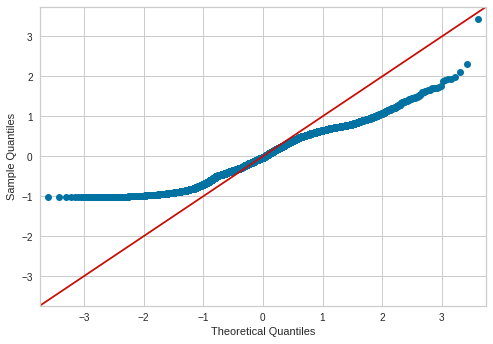

Statistics=0.973, p=0.000
Sample does not look Gaussian (reject H0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [487]:
# GRÁFICO QQ - NORMALIDADE #

sm.qqplot(modelo_residuo, line="45")
plt.show()

#Teste Shapiro-Wilk
from scipy.stats import shapiro
stat, p = shapiro(modelo_residuo)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:print('Sample looks Gaussian (fail to reject H0)')
else:print('Sample does not look Gaussian (reject H0)')

* Não há distribuição normal dos resíduos.

In [488]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

#Heteroskedasticity tests

#Breush-Pagan test:

name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(modelo_residuo, results.model.exog)
print(lzip(name, test))
print()

#Goldfeld-Quandt test

name = ["Goldfeld-Quandt - F statistic", "p-value"]
test = sms.het_goldfeldquandt(modelo_residuo, results.model.exog)
print(lzip(name, test))

[('Lagrange multiplier statistic', 1399.601700868449), ('p-value', 2.564367768462909e-306), ('f-value', 1807.170649256431), ('f p-value', 0.0)]

[('Goldfeld-Quandt - F statistic', 1.008941142118879), ('p-value', 0.4021885564970902)]


* Não há homocedasticidade.

* Com esse modelo atual, não é possivel fazer inferência causal.

# Conclusão

* No experimento 1:
  * Com 5 clusters do KMeans, as distâncias interclusters não ficaram adequadas.
* No experimento 2:
  * O grupo que mais gosta de entrega grátis é o 1 e 3, com 100% dos pedidos feitos com entrega grátis.
  * O grupo mais fiel e valioso é o 3.
  * O que diferencia o grupo 0 e 3 é que nos top 10 pratos mais pedidos, o primeiro gosta mais de bebida do que pedir no mercado, já o segundo gosta mais de pedir mercado do que bebida.
  * Entre o grupo 0 e 3, não foi possível afirmar causalidade da entrega grátis em relação ao aumento de CLTV.